<a href="https://colab.research.google.com/github/yfb2022/HANA-Credit-Dashboard/blob/main/CREDIT_HANA_test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna
!pip install catboost
!pip install optuna-integration
!pip install dice-ml
!pip install shap
!pip install toad
!pip install optbinning
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.9/213.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 23.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successf

In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle
import math
import optuna
import xgboost as xgb
import toad
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import early_stopping, LGBMClassifier
import lightgbm as lgb
import sklearn.datasets
import sklearn.metrics
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score, log_loss, balanced_accuracy_score, auc, roc_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import KFold
import torch
from scipy.stats import ks_2samp

In [3]:
import pandas as pd
cb_chunk = pd.read_csv('/content/drive/MyDrive/CB_data/card_cbs.csv',
                       chunksize=1000000,
                       index_col = 0,
                       low_memory=True)
card_cb = pd.concat(cb_chunk, ignore_index=True)
note = pd.read_csv('/content/drive/MyDrive/CB_data/note.csv', encoding='cp949')

In [ ]:
# 연령 필터링
card_cb = card_cb[card_cb['AGE'] <= 30]

def nullity_preprocess(df):
  missing_ratios = df.isnull().mean()
  above_0 = missing_ratios[missing_ratios > 0].index.tolist()
  below_10 = missing_ratios[(missing_ratios <= 0.1) & (missing_ratios > 0)].index.tolist()
  between_10_50 = missing_ratios[(missing_ratios > 0.1) & (missing_ratios < 0.5)].index.tolist()
  above_50 = missing_ratios[(missing_ratios >= 0.5) & (missing_ratios < 1)].index.tolist()
  above_100 = missing_ratios[missing_ratios == 1].index.tolist()
  for col in above_100:
    df.drop(columns = col, inplace=True)
  for col in tqdm(below_10 + between_10_50):
    df[col] = df.groupby('CUST_ID')[col].transform(lambda x: x.ffill().bfill())
  return df

card_cb = nullity_preprocess(card_cb)

# "Poor" 값 생성
threshold = 30
card_cb['Poor'] = np.where(card_cb['PYE_MAX_DLQ_DAY'] >= 30, 1, 0)
card_cb['BASE_YM'] = pd.to_datetime(card_cb['BASE_YM'])
split_date = '2022-09-01'
train = card_cb[card_cb['BASE_YM'] < split_date].reset_index(drop = True)
test = card_cb[card_cb['BASE_YM'] >= split_date].reset_index(drop = True)

100%|██████████| 27/27 [05:54<00:00, 13.13s/it]


In [ ]:
# Checkpoint
test.to_csv('/content/drive/MyDrive/CB_data/cb_test.csv', index=False)
train.to_csv('/content/drive/MyDrive/CB_data/cb_train.csv', index=False)

In [7]:
def credit_grade(feature):
  if feature in range(942, 1001):
    return 1
  elif feature in range(891, 942):
    return 2
  elif feature in range(832, 891):
    return 3
  elif feature in range(768, 832):
    return 4
  elif feature in range(698, 768):
    return 5
  elif feature in range(630, 698):
    return 6
  elif feature in range(530, 630):
    return 7
  elif feature in range(454, 530):
    return 8
  elif feature in range(335, 454):
    return 9
  else:
    return 10

BASE_YM
2021-03-01    0.203582
2021-06-01    0.203582
2021-09-01    0.203582
2022-03-01    0.167504
2022-06-01    0.167504
Name: Poor, dtype: float64


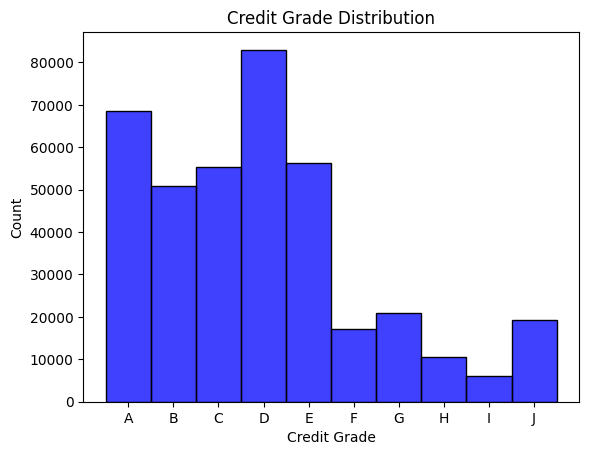

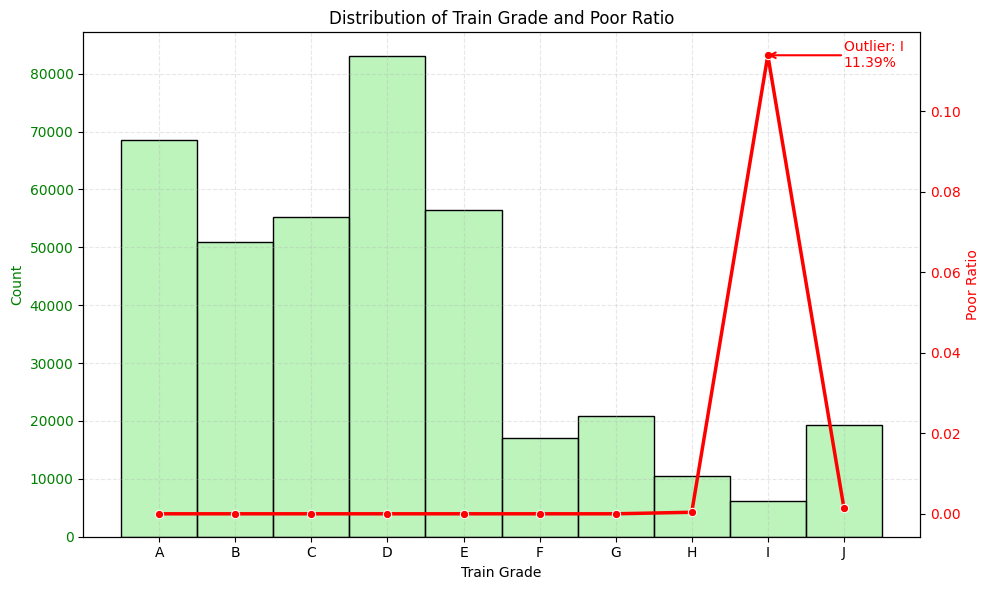

In [ ]:
# 데이터셋 분리 및 신용점수 분포 확인 # Reference
yearly_poor = train.groupby('BASE_YM')['Poor'].sum()
yearly_total = train.groupby('BASE_YM')['Poor'].count()
poor_ratio = yearly_poor / yearly_total * 100

print(poor_ratio)

train_grade = train['PYE_SC0000000'].apply(credit_grade).sort_values()

sns.histplot(train_grade, color='blue')
plt.title("Credit Grade Distribution")
plt.xlabel("Credit Grade")
plt.show()

fig, ax1 = plt.subplots(figsize=(10, 6))
sns.histplot(train_grade, color='lightgreen', alpha=0.6, ax=ax1, bins=20)
ax1.set_xlabel('Train Grade')
ax1.set_ylabel('Count', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax2 = ax1.twinx()
poor_ratio = train.groupby(train_grade)['Poor'].mean()
sns.lineplot(x=poor_ratio.index, y=poor_ratio.values, color='red', marker='o', linewidth=2.5, ax=ax2)
ax2.set_ylabel('Poor Ratio', color='red')
ax2.tick_params(axis='y', labelcolor='red')
max_index = poor_ratio.idxmax()
max_value = poor_ratio.max()
ax2.annotate(
    f'Outlier: {max_index}\n{max_value:.2%}',
    xy=(max_index, max_value),              # 화살표 끝 (타겟 포인트)
    xytext=(chr(ord(max_index) + 1), max_value),  # 화살표 시작 (텍스트 위치) - 오른쪽으로 이동
    arrowprops=dict(
        arrowstyle='->',
        color='red',
        shrinkA=0, shrinkB=0,
        lw=1.5
    ),
    fontsize=10,
    color='red',
    ha='left',
    va='center'
)
plt.title('Distribution of Train Grade and Poor Ratio')
ax1.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew

def determine_winsor_limit(df, column):
    # IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_ratio = ((df[column] < lower_bound) | (df[column] > upper_bound)).mean()
    skew_value = skew(df[column])

    if outlier_ratio < 0.05 and abs(skew_value) < 1.0:
        return [0.01, 0.99]
    elif 0.05 <= outlier_ratio < 0.1 or (1.0 <= abs(skew_value) < 2.0):
        return [0.05, 0.95]  # 중간 Winsorization
    else:
        return [0.1, 0.9]  # 강한 Winsorization

# 데이터 변환
exclude_list = ['Poor', 'BASE_YM', 'CUST_ID', 'TYPE', 'AGE', 'PYE_SC0000000', 'SEX']
for col in tqdm(train.columns):
  if col in exclude_list:
    continue
  is_categorical = note.loc[note['필드명'] == col, '코드여부'].iloc[0] == 'Y'
  if is_categorical:
    train[col] = train[col].astype(str)

# 수치형 데이터 (이상치 처리)
train_num = train.select_dtypes(include = 'number')
train_num.drop(columns = ['AGE', 'PYE_SC0000000', 'Poor'], inplace = True)

for col in tqdm(train_num.columns):
    # 왜도 기준 설정
    limit = determine_winsor_limit(train, col)
    # Winsorization 적용 (Train에서 학습한 임계값을 Test에도 적용)
    Q1, Q3 = train[col].quantile(limit)
    train[col] = np.clip(train[col], Q1, Q3)
    test[col] = np.clip(test[col], Q1, Q3)
    # Yeo-Johnson 변환 (왜도가 높은 경우만 적용)
    if train[col].skew() > 2.0:
        pt = PowerTransformer(method='yeo-johnson')
        train[col] = pt.fit_transform(train[col].values.reshape(-1, 1)).flatten()
        test[col] = pt.transform(test[col].values.reshape(-1, 1)).flatten()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
<ipython-input-7-c2d961fe3b5b>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col] = np.clip(test[col], Q1, Q3)
<ipython-input-7-c2d961fe3b5b>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col] = np.clip(train[col], Q1, Q3)
<ipython-input-7-c2d961fe3b5b>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [ ]:
def FC(df, ref_df, nbins):
    effective_columns = []
    columns_to_drop = []
    effective_df_data = []

    columns_to_iter = df.columns.tolist()
    for col in tqdm(columns_to_iter):
        if col in ['Poor', 'BASE_YM', 'CUST_ID', 'TYPE', 'AGE', 'SEX']:
            continue
        if df[col].notnull().sum() == 0:
            columns_to_drop.append(col)
            continue
        is_categorical = ref_df.loc[ref_df['필드명'] == col, '코드여부'].iloc[0] == 'Y'

        if is_categorical:
            df[col] = df[col].astype(str)
            grouped = df.groupby(col, observed = False).agg(
                total=('Poor', 'count'),
                bad=('Poor', 'sum')
            )
        else:
            bin_result = pd.qcut(df[col], nbins, duplicates='drop')
            grouped = df.groupby(bin_result, observed = False).agg(
                total=('Poor', 'count'),
                bad=('Poor', 'sum')
                )
            grouped.index = grouped.index.astype(str)

        grouped['good'] = grouped['total'] - grouped['bad']
        tp = grouped['bad'] / grouped['bad'].sum()
        ntp = grouped['good'] / grouped['good'].sum()
        woe = np.log((tp + 1e-10) / (ntp + 1e-10))
        iv_raw = (tp - ntp) * woe
        iv = iv_raw.sum()
        iv_scaled = int(iv * 10000) / 100

        if iv >= 0.1:
            effective_columns.append(col)
            effective_df_data.append({'필드명': col, '설명' : ref_df.loc[ref_df['필드명'] == col , '설명'].iloc[0],
                                      'IV': iv_scaled})
        else:
            columns_to_drop.append(col)

    df.drop(columns=columns_to_drop, inplace=True)
    effective_df = pd.DataFrame(effective_df_data, columns=['필드명', '설명' ,'IV'])
    return df, effective_df

In [ ]:
# IV
train_df, effective_df = FC(train, note, 20)
test_df = test[train_df.columns]
for col in train_df.columns:
    test_df[col] = test_df[col].astype(train_df[col].dtype)

  0%|          | 0/669 [00:00<?, ?it/s]<ipython-input-8-435437f8cb7d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str)
<ipython-input-8-435437f8cb7d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str)
  1%|          | 6/669 [00:00<00:18, 36.39it/s]<ipython-input-8-435437f8cb7d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [ ]:
import scipy.stats as stats
import pandas as pd
import statsmodels.api as sm

# 범주형 변수 2개 선정 (예: '대출상품', '불량 여부')
def dep_test(column_lst):
  drop_lst = []
  temp_df = train_df.copy()
  exclude_list = ['Poor', 'BASE_YM', 'CUST_ID', 'TYPE', 'AGE', 'PYE_SC0000000', 'SEX']
  selected_columns = [col for col in column_lst if col not in exclude_list]
  y = temp_df['Poor']
  for col in tqdm(selected_columns):
    X = temp_df[col]
    if X.dtype == 'object':
      cross_table = pd.crosstab(X, y)
      chi2, p, dof, expected = stats.chi2_contingency(cross_table)
      if p >= 0.05:
        drop_lst.append(col)
    else:
      group1 = temp_df[temp_df['Poor'] == 1][col]
      group2 = temp_df[temp_df['Poor'] == 0][col]
      group1 = group1[~np.isnan(group1)]
      group2 = group2[~np.isnan(group2)]
      u_stat, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
      if p_value >= 0.05:
        drop_lst.append(col)
  return drop_lst

drop_list = dep_test(train_df.columns)
train_df.drop(columns=drop_list, inplace=True)
test_df.drop(columns=drop_list, inplace=True)

100%|██████████| 245/245 [01:35<00:00,  2.58it/s]
<ipython-input-10-8472b9367d74>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=drop_list, inplace=True)
<ipython-input-10-8472b9367d74>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=drop_list, inplace=True)


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 상관관계 계산 및 대상 피처 선정
exclude_list = ['BASE_YM', 'CUST_ID', 'TYPE', 'AGE', 'PYE_SC0000000', 'SEX']
numeric_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
selected_columns = [col for col in numeric_columns if col not in exclude_list]
corr_matrix = train_df[selected_columns].corr().abs()

# 2. effective_df에서 IV 값을 미리 딕셔너리로 생성 (키: 필드명, 값: IV)
iv_dict = effective_df.set_index('필드명')['IV'].to_dict()

# # 3. 상관관계가 높은 피처 쌍 수집 (한 번만 수집)
high_corr_pairs = []
for i in range(len(selected_columns)):
    for j in range(i+1, len(selected_columns)):
        col_i = selected_columns[i]
        col_j = selected_columns[j]
        if corr_matrix.loc[col_i, col_j] >= 0.9:
            high_corr_pairs.append((col_i, col_j))

corr_df = pd.DataFrame()
feature = []
explanation = []
target_corr = []
IV_pair = []
vif_pair = []

def get_description(x):
  return note['설명'][note['필드명'] == x].iloc[0]

for pair in high_corr_pairs:
    feature.append(pair)
    explanation.append(f'{get_description(pair[0])} - {get_description(pair[1])}')
    target_corr.append(f'{corr_matrix.loc[pair[0], "Poor"]} - {corr_matrix.loc[pair[1], "Poor"]}')
    IV_pair.append(f'{iv_dict[pair[0]]} - {iv_dict[pair[1]]}')
    X = train_df[[pair[0], pair[1]]].dropna()
    vif_pair.append((variance_inflation_factor(X.values, 0), variance_inflation_factor(X.values, 1)))

corr_df['feature'] = feature
corr_df['explanation'] = explanation
corr_df['target_corr'] = target_corr
corr_df['IV_pair'] = IV_pair
corr_df['VIF_pair'] = vif_pair

In [ ]:
# Suspended #
# Phase1
cols_to_drop = [col for col in train_df.columns if any(x in col for x in ['R3M', 'R6M', 'R9M'])]
train_df.drop(columns=cols_to_drop, inplace=True)
test_df.drop(columns = cols_to_drop, inplace = True)

# Phase2
cols_to_drop2 = ['PYE_NET_ASST', 'PYE_C18233003' , 'PYE_C18233004' , 'PYE_C18233005',
                'PYE_C1L120196', 'PYE_L1021003P', 'PYE_L1021006P' , 'R12M_SSM_AMT' , 'CPYT_M_MART_H_CPPY_CUM_AMT_RT',
                'CPYT_M_MART_E_AMT_RT' , 'CPYT_M_MART_H_AMT_RT' , 'CPYT_SSM_CUM_AMT_RT' , 'CPYT_M_MART_E_CUM_AMT_RT',
                'CPYT_M_MART_H_CUM_AMT_RT' ,'CPYT_SSM_CPPY_CUM_AMT_RT']
train_df.drop(columns=cols_to_drop2, inplace=True)
test_df.drop(columns=cols_to_drop2, inplace=True)

<ipython-input-12-a6c308806bdd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=cols_to_drop, inplace=True)
<ipython-input-12-a6c308806bdd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns = cols_to_drop, inplace = True)
<ipython-input-12-a6c308806bdd>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=cols_to_drop2, inplace=True)
<ipython-input-12-a6c308806bdd>:13: Setti

In [ ]:
# Suspended #
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import copy
import toad
from sklearn.impute import KNNImputer


# 삭제할 컬럼 리스트 구성 (to_remove 는 이미 iterable 형태여야 함 : list(to_remove))
columns_to_drop = ['BASE_YM', 'AGE' ,'CUST_ID', 'TYPE', 'PYE_SC0000000', 'SEX']
train_df.drop(columns=columns_to_drop, inplace=True)
test_df.drop(columns=columns_to_drop, inplace=True)

# 학습 데이터셋 분리
x_train = train_df.drop('Poor', axis = 1)
x_test = test_df.drop('Poor', axis = 1)
y_train = train_df['Poor']
y_test = test_df['Poor']

class DataSplitter:
    def __init__(self, x_train: pd.DataFrame, x_test: pd.DataFrame, y_train: pd.Series = None):
        self.x_train = x_train.copy()
        self.x_test = x_test.copy()
        self.y_train = y_train
        self.numeric_features = x_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
        self.categorical_features = x_train.select_dtypes(include=['object']).columns.tolist()

    def encode_categorical(self, method="label"):
        if method == "onehot":
            # One-Hot Encoding
            self.x_train = pd.get_dummies(self.x_train)
            self.x_test = pd.get_dummies(self.x_test)
            all_columns = set(self.x_train.columns) | set(self.x_test.columns)
            self.x_train = self.x_train.reindex(columns=all_columns, fill_value=0)
            self.x_test = self.x_test.reindex(columns=all_columns, fill_value=0)

        elif method == "label":
            # Label Encoding
            # self.cat_cardinalities = []
            # self.cat_column_index = [self.x_train.columns.get_loc(col) for col in self.categorical_features]
            for col in tqdm(self.categorical_features):
                le = LabelEncoder()
                all_categories = np.concatenate([self.x_train[col].astype(str), self.x_test[col].astype(str)])
                le.fit(all_categories)
                self.x_train[col] = le.transform(self.x_train[col].astype(str))
                self.x_test[col] = le.transform(self.x_test[col].astype(str))
                # Cardinalities 저장
                # max_cat = len(le.classes_)#max(self.x_train[col].max(), self.x_test[col].max()) + 1
                # self.cat_cardinalities.append(max_cat)

    def scale_numeric(self):
        scaler = MinMaxScaler()
        self.x_train[self.numeric_features] = scaler.fit_transform(self.x_train[self.numeric_features])
        self.x_test[self.numeric_features] = scaler.transform(self.x_test[self.numeric_features])

    def combiner(self):
        combiner = toad.transform.Combiner()
        combiner.fit(self.x_train[self.numeric_features], y=self.y_train, method='dt', min_samples=0.05)
        self.x_train[self.numeric_features] = combiner.transform(self.x_train[self.numeric_features])
        self.x_test[self.numeric_features] = combiner.transform(self.x_test[self.numeric_features])

    def preprocess(self, method="ml"):
        if method == "ml":
            self.combiner()
            self.encode_categorical(method="onehot")
        elif method == "dl":
            self.scale_numeric()
            self.encode_categorical(method="label")
            return self.x_train, self.x_test #, self.cat_column_index, self.cat_cardinalities
        return self.x_train, self.x_test

splitter = DataSplitter(x_train, x_test, y_train)
x_train_ml, x_test_ml = splitter.preprocess(method="ml")

splitter = DataSplitter(x_train, x_test)
x_train_dl, x_test_dl  = splitter.preprocess(method="dl")

train_rows = y_train.count()
test_rows = y_test.count()

print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(x_train_ml.shape , x_test_ml.shape))
print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_rows)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_rows)

<ipython-input-13-769cfa55badf>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=columns_to_drop, inplace=True)
<ipython-input-13-769cfa55badf>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=columns_to_drop, inplace=True)
100%|██████████| 18/18 [00:02<00:00,  6.58it/s]

학습 세트 Shape:(388050, 235), 테스트 세트 Shape:(155220, 235)
 학습 세트 레이블 값 분포 비율
Poor
0    0.998108
1    0.001892
Name: count, dtype: float64

 테스트 세트 레이블 값 분포 비율
Poor
0    0.998325
1    0.001675
Name: count, dtype: float64


In [ ]:
from scipy.stats import normaltest

missing_ratio = x_train_dl.isnull().mean()
col_to_impute = missing_ratio[missing_ratio < 0.1].index
col_to_reg = missing_ratio[(missing_ratio >= 0.1) & (missing_ratio < 0.5)].index
col_to_delete = missing_ratio[missing_ratio >= 0.5].index

for col in col_to_impute:
  _, p = normaltest(x_train_dl[col].dropna())
  if p <= 0.05:
    x_train_dl[col].fillna(x_train_dl[col].median(), inplace=True)
    x_test_dl[col].fillna(x_train_dl[col].median(), inplace=True)
  else:
    x_train_dl[col].fillna(x_train_dl[col].mean(), inplace=True)
    x_test_dl[col].fillna(x_train_dl[col].mean(), inplace=True)

x_train_dl.drop(columns = col_to_delete, inplace=True)
x_test_dl.drop(columns = col_to_delete, inplace=True)

initial_categorical_features = splitter.categorical_features
categorical_features = [col for col in initial_categorical_features if col in x_train_dl.columns]
cat_column_index = [x_train_dl.columns.get_loc(col) for col in categorical_features]
cat_cardinalities = [x_train_dl[col].nunique() for col in categorical_features]


<ipython-input-14-8fb52e0f72d8>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x_train_dl[col].fillna(x_train_dl[col].median(), inplace=True)
<ipython-input-14-8fb52e0f72d8>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [ ]:
# dl 1, ml 2
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
x_train_ml, y_train_ml = smote.fit_resample(x_train_ml, y_train)
x_train_dl, y_train_dl = smote.fit_resample(x_train_dl, y_train)

print("SMOTE 적용 후 클래스 분포:")
print(y_train_ml.value_counts(normalize=True))
print(y_train_dl.value_counts(normalize=True))

SMOTE 적용 후 클래스 분포:
Poor
0    0.5
1    0.5
Name: proportion, dtype: float64
Poor
0    0.5
1    0.5
Name: proportion, dtype: float64


In [ ]:
train_ml = pd.concat([x_train_ml, y_train_ml], axis=1)
test_ml = pd.concat([x_test_ml, y_test], axis=1)

train_dl = pd.concat([x_train_dl, y_train_dl], axis=1)
test_dl = pd.concat([x_test_dl, y_test], axis=1)

cat_col_df = pd.DataFrame(cat_column_index, columns = ['cat_column_index'])
cardinal_df = pd.DataFrame(cat_cardinalities, columns = ['cat_cardinalities'])

train_ml.to_csv('/content/drive/MyDrive/CB_data/train_ml.csv')
test_ml.to_csv('/content/drive/MyDrive/CB_data/test_ml.csv')
train_dl.to_csv('/content/drive/MyDrive/CB_data/train_dl.csv')
test_dl.to_csv('/content/drive/MyDrive/CB_data/test_dl.csv')
cat_col_df.to_csv('/content/drive/MyDrive/CB_data/cat_col_df.csv', index = False)
cardinal_df.to_csv('/content/drive/MyDrive/CB_data/cardinal_df.csv', index = False)

In [9]:
cat_column_index = pd.read_csv('/content/drive/MyDrive/CB_data/cat_col_df.csv')
cat_cardinalities = pd.read_csv('/content/drive/MyDrive/CB_data/cardinal_df.csv')


train_ml = pd.read_csv('/content/drive/MyDrive/CB_data/train_ml.csv',
                         index_col = 0,
                         chunksize = 1000000,
                         low_memory=True)
train_ml = pd.concat(train_ml, ignore_index=True)


test_ml = pd.read_csv('/content/drive/MyDrive/CB_data/test_ml.csv',
                        index_col = 0,
                        chunksize = 1000000,
                        low_memory = True)
test_ml = pd.concat(test_ml, ignore_index=True)

train_dl = pd.read_csv('/content/drive/MyDrive/CB_data/train_dl.csv',
                        index_col = 0,
                        chunksize = 1000000,
                        low_memory = True)
train_dl = pd.concat(train_dl, ignore_index=True)

test_dl = pd.read_csv('/content/drive/MyDrive/CB_data/test_dl.csv',
                        index_col = 0,
                        chunksize = 1000000,
                        low_memory = True)
test_dl = pd.concat(test_dl, ignore_index=True)


x_train_ml = train_ml.drop('Poor', axis = 1)
x_test_ml = test_ml.drop('Poor', axis = 1)
y_train_ml = train_ml['Poor']
y_test_ml = test_ml['Poor']

x_train_dl = train_dl.drop('Poor', axis = 1)
x_test_dl = test_dl.drop('Poor', axis = 1)
y_train_dl = train_dl['Poor']
y_test_dl = test_dl['Poor']

In [ ]:
from collections import Counter

def obj_lgb(trial):
    param = {
        "random_state": 42,
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type" : "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-3, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-3, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "max_depth": trial.suggest_int("max_depth", 3, 16),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 3, 5),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
    }

    dtrain = lgb.Dataset(x_train_ml, label=y_train_ml)
    dtest = lgb.Dataset(x_test_ml, label=y_test_ml)
    gbm = lgb.train(param,
                    dtrain,
                    valid_sets=[dtest],
                    callbacks=[LightGBMPruningCallback(trial, "auc")]
                    )
    preds = gbm.predict(x_test_ml)
    pred_labels = np.rint(preds)
    score = f1_score(y_test_ml, pred_labels)
    return score


def obj_cat(trial):
    param = {
        "random_state": 42,
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "depth": trial.suggest_int("depth", 6, 10),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "eval_metric": "F1",
        "verbose": False
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1.0, log = True)

    model = CatBoostClassifier(**param)

    model.fit(x_train_ml,
              y_train_ml,
              eval_set=[(x_test_ml, y_test_ml)],
              verbose=False,
              early_stopping_rounds=100,
              callbacks = [CatBoostPruningCallback(trial, "F1")]
              )

    preds = model.predict(x_test_ml)
    pred_labels = np.rint(preds)
    score = f1_score(y_test_ml, pred_labels)
    return score

def obj_xgb(trial):
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric" : "auc",
        "early_stopping_rounds" : 100,
        "tree_method" : "hist",
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "lambda": trial.suggest_float("lambda", 1e-2, 1.0, log = True),
        "alpha": trial.suggest_float("alpha", 1e-2, 1.0, log = True),
        "gamma": trial.suggest_float("gamma", 1e-2, 1.0, log = True),
        "grow_policy" : trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight" : trial.suggest_int("min_child_weight", 2, 10),
        "eta" : trial.suggest_float("eta", 1e-2, 0.2, log=True),
    }

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-2, 0.3, log =True)
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-2, 0.3, log =True)

    dtrain = xgb.DMatrix(x_train_ml, label=y_train_ml)
    dtest = xgb.DMatrix(x_test_ml, label=y_test_ml)
    model = xgb.train(param,
                      dtrain,
                      evals=[(dtest, "eval")],
                      callbacks = [XGBoostPruningCallback(trial, "eval-auc")]
                      )
    preds = model.predict(dtest)
    pred_labels = np.rint(preds)
    score = f1_score(y_test_ml, pred_labels)
    return score


def obj_tab(trial):
   n_d_a = trial.suggest_int("n_d", 8, 64)
   param = {
        "verbose" : 0,
        "cat_idxs" : cat_column_index['cat_column_index'].tolist(),
        "cat_dims" : cat_cardinalities['cat_cardinalities'].tolist(),
        "scheduler_fn" :  torch.optim.lr_scheduler.ReduceLROnPlateau,
        "mask_type": trial.suggest_categorical("mask_type", ["entmax", "sparsemax"]),
        "n_d" : n_d_a,
        "n_a" : n_d_a,
        "n_steps" : trial.suggest_int("n_steps", 3, 10),
        "gamma" : trial.suggest_float("gamma", 1.0, 2.0, log=True),
        "n_independent" : trial.suggest_int("n_independent", 1, 5),
        "n_shared" : trial.suggest_int("n_shared", 1, 5)
    }

   model = TabNetClassifier(**param)
   model.fit(x_train_dl.values,
             y_train_dl.values,
             eval_set=[(x_test_dl.values, y_test_dl.values)],
             eval_metric= ['auc']
             )
   preds = model.predict(x_test_dl.values)
   score = f1_score(y_test_dl.values, preds)
   return score

def optimizer(objective):
  study = optuna.create_study(direction="maximize",
                              pruner=optuna.pruners.MedianPruner())
  study.optimize(objective,
                 n_trials=100,
                 timeout=600,
                 n_jobs = -1,
                 show_progress_bar = True)

  trial = study.best_trial
  print("Number of finished trials: {}".format(len(study.trials)))
  print("Best trial:")
  print("  Value: {}".format(trial.value))
  print("  Params: ")
  for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
  return trial

In [ ]:
# Model Instance
from gc import callbacks
from optuna.samplers import TPESampler
from lightgbm import log_evaluation
import lightgbm as lgb
from optuna.integration import XGBoostPruningCallback, CatBoostPruningCallback, LightGBMPruningCallback

def instantiate_model(model_name, trial):
    params = trial.params
    if model_name == "CatBoost":
        return CatBoostClassifier(**params, verbose=False, random_state=42)
    elif model_name == "XGBoost":
        return XGBClassifier(**params, verbosity=0, random_state=42)
    elif model_name == "LightGBM":
        return LGBMClassifier(**params, verbosity=-1, random_state=42)
    elif model_name == 'TabNet':
        return TabNetClassifier(**params)
    else:
        raise ValueError(f"Unknown model name: {model_name}")

# Model Evaluation
def evaluate_model(model, X_train, y_train, X_test, y_test):
    if isinstance(model, TabNetClassifier):
      X_train = X_train.values
      X_test = X_test.values
      y_train = y_train.values
      y_test = y_test.values
    model.fit(X_train, y_train)
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_train_pred = model.predict(X_train)
    y_test_prob = model.predict_proba(X_test)[:, 1]
    y_test_pred = model.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
    metrics ={
        "Balanced_Accuracy": balanced_accuracy_score(y_test, y_test_pred),
        "PR_AUC": auc(recall, precision),
        "F1-score": f1_score(y_test, y_test_pred),
        "Log Loss": log_loss(y_test, y_test_prob),
         }
    return metrics

# Optuna
xgb_trial = optimizer(obj_xgb)
lgb_trial = optimizer(obj_lgb)
cat_trial = optimizer(obj_cat)
tab_trial = optimizer(obj_tab)


models = {
    "TabNet": instantiate_model("TabNet", tab_trial),
    "CatBoost": instantiate_model("CatBoost", cat_trial),
    "XGBoost": instantiate_model("XGBoost", xgb_trial),
    "LightGBM": instantiate_model("LightGBM", lgb_trial)
    }

results = {}
for name, model in tqdm(models.items(), desc="Model Evaluation"):
    if name == 'TabNet':
        results[name] = evaluate_model(model, x_train_dl, y_train_dl, x_test_dl, y_test_dl)
    else:
      results[name] = evaluate_model(model, x_train_ml, y_train_ml, x_test_ml, y_test_ml)


results_df = pd.DataFrame(results).T
display(results_df)

[I 2025-04-17 01:51:43,814] A new study created in memory with name: no-name-645c5153-c63a-4b43-b45e-0102b66cbbdd


  0%|          | 0/100 [00:00<?, ?it/s]

[0]	eval-auc:0.93958
[0]	eval-auc:0.88643
[0]	eval-auc:0.93201[0]	eval-auc:0.92178
[0]	eval-auc:0.93423

[0]	eval-auc:0.90518
[0]	eval-auc:0.95786
[1]	eval-auc:0.95974
[0]	eval-auc:0.95935
[1]	eval-auc:0.94267
[2]	eval-auc:0.96161
[1]	eval-auc:0.96659
[1]	eval-auc:0.96733
[1]	eval-auc:0.92465
[1]	eval-auc:0.94478
[2]	eval-auc:0.97286
[3]	eval-auc:0.95714
[1]	eval-auc:0.93167
[2]	eval-auc:0.96434
[2]	eval-auc:0.98660
[4]	eval-auc:0.95861
[3]	eval-auc:0.98351
[1]	eval-auc:0.96253
[3]	eval-auc:0.97736
[5]	eval-auc:0.96263
[3]	eval-auc:0.99141
[2]	eval-auc:0.95252
[2]	eval-auc:0.96214
[4]	eval-auc:0.98784
[2]	eval-auc:0.96126
[6]	eval-auc:0.96033
[4]	eval-auc:0.98938
[4]	eval-auc:0.99393
[5]	eval-auc:0.98894
[7]	eval-auc:0.96339
[2]	eval-auc:0.98340
[5]	eval-auc:0.99118
[6]	eval-auc:0.98939
[5]	eval-auc:0.99488
[8]	eval-auc:0.96499
[6]	eval-auc:0.98991
[3]	eval-auc:0.95847
[7]	eval-auc:0.99071
[9]	eval-auc:0.96597
[3]	eval-auc:0.96947
[6]	eval-auc:0.99431
[3]	eval-auc:0.97560
[I 2025-04-17

[I 2025-04-17 01:57:39,422] A new study created in memory with name: no-name-e67ed8fd-138a-4189-b199-f3b915bde381


Number of finished trials: 100
Best trial:
  Value: 0.2957540263543192
  Params: 
    booster: dart
    max_depth: 10
    lambda: 0.11396090770751452
    alpha: 0.07934848263527312
    gamma: 0.03251361255690633
    grow_policy: lossguide
    subsample: 0.7180767734870912
    colsample_bytree: 0.5903595734182899
    min_child_weight: 3
    eta: 0.10612314783330302
    sample_type: weighted
    normalize_type: tree
    skip_drop: 0.06587680830244128
    rate_drop: 0.018868571260956347


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-04-17 01:58:24,737] Trial 0 finished with value: 0.15 and parameters: {'lambda_l1': 0.0012238741755764366, 'lambda_l2': 0.0020227582088351787, 'num_leaves': 173, 'max_depth': 3, 'feature_fraction': 0.9906026550253766, 'bagging_fraction': 0.6898382897840258, 'bagging_freq': 4, 'min_child_samples': 30}. Best is trial 0 with value: 0.15.
[I 2025-04-17 01:58:27,322] Trial 7 finished with value: 0.39928057553956836 and parameters: {'lambda_l1': 0.527105851352956, 'lambda_l2': 0.0012157315785562201, 'num_leaves': 30, 'max_depth': 5, 'feature_fraction': 0.9981794939985954, 'bagging_fraction': 0.5141492414675746, 'bagging_freq': 4, 'min_child_samples': 46}. Best is trial 7 with value: 0.39928057553956836.
[I 2025-04-17 01:58:38,162] Trial 5 finished with value: 0.18678038379530917 and parameters: {'lambda_l1': 0.6298425400599048, 'lambda_l2': 0.29519812530524636, 'num_leaves': 7, 'max_depth': 5, 'feature_fraction': 0.5191949321220302, 'bagging_fraction': 0.6369793504803483, 'bagging_fr

[I 2025-04-17 02:03:13,809] A new study created in memory with name: no-name-f407ea00-8b63-468d-8003-0ad27256a989


[I 2025-04-17 02:03:13,643] Trial 99 pruned. Trial was pruned at iteration 0.
[I 2025-04-17 02:03:13,734] Trial 96 pruned. Trial was pruned at iteration 12.
Number of finished trials: 100
Best trial:
  Value: 0.8705882352941177
  Params: 
    lambda_l1: 0.18449198185852217
    lambda_l2: 0.11744865966918855
    num_leaves: 189
    max_depth: 13
    feature_fraction: 0.6789667898537544
    bagging_fraction: 0.7064920991653019
    bagging_freq: 3
    min_child_samples: 13


  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-4-eb19197635d1>:57: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  callbacks = [CatBoostPruningCallback(trial, "F1")]


[I 2025-04-17 02:06:36,468] Trial 1 finished with value: 0.7768014059753954 and parameters: {'objective': 'Logloss', 'depth': 9, 'bootstrap_type': 'Bernoulli', 'subsample': 0.21644465710855307}. Best is trial 1 with value: 0.7768014059753954.


<ipython-input-4-eb19197635d1>:57: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  callbacks = [CatBoostPruningCallback(trial, "F1")]


[I 2025-04-17 02:07:39,673] Trial 7 finished with value: 0.7875457875457875 and parameters: {'objective': 'Logloss', 'depth': 8, 'bootstrap_type': 'Bernoulli', 'subsample': 0.2120228494392709}. Best is trial 7 with value: 0.7875457875457875.


<ipython-input-4-eb19197635d1>:57: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  callbacks = [CatBoostPruningCallback(trial, "F1")]


[I 2025-04-17 02:11:11,953] Trial 2 finished with value: 0.7307692307692307 and parameters: {'objective': 'Logloss', 'depth': 6, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.13592841450584592}. Best is trial 7 with value: 0.7875457875457875.


<ipython-input-4-eb19197635d1>:57: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  callbacks = [CatBoostPruningCallback(trial, "F1")]


[I 2025-04-17 02:12:15,421] Trial 4 finished with value: 0.7912457912457912 and parameters: {'objective': 'Logloss', 'depth': 10, 'bootstrap_type': 'MVS'}. Best is trial 4 with value: 0.7912457912457912.


<ipython-input-4-eb19197635d1>:57: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  callbacks = [CatBoostPruningCallback(trial, "F1")]


[I 2025-04-17 02:14:51,581] Trial 5 finished with value: 0.7058823529411765 and parameters: {'objective': 'CrossEntropy', 'depth': 7, 'bootstrap_type': 'MVS'}. Best is trial 4 with value: 0.7912457912457912.
[I 2025-04-17 02:14:52,565] Trial 10 finished with value: 0.6502057613168725 and parameters: {'objective': 'CrossEntropy', 'depth': 8, 'bootstrap_type': 'Bernoulli', 'subsample': 0.12445287698540305}. Best is trial 4 with value: 0.7912457912457912.
[I 2025-04-17 02:14:52,568] Trial 11 finished with value: 0.25298081907724207 and parameters: {'objective': 'CrossEntropy', 'depth': 7, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.418499195796356}. Best is trial 4 with value: 0.7912457912457912.
[I 2025-04-17 02:15:05,557] Trial 3 finished with value: 0.8160291438979964 and parameters: {'objective': 'CrossEntropy', 'depth': 10, 'bootstrap_type': 'Bernoulli', 'subsample': 0.2074622543970344}. Best is trial 3 with value: 0.8160291438979964.
[I 2025-04-17 02:15:32,916] Trial 0 fi

[I 2025-04-17 02:19:49,283] A new study created in memory with name: no-name-485b0ae8-c69a-497f-8804-3e353455c6e2


[I 2025-04-17 02:19:49,272] Trial 6 finished with value: 0.8330341113105925 and parameters: {'objective': 'CrossEntropy', 'depth': 10, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.288738506396867}. Best is trial 6 with value: 0.8330341113105925.
Number of finished trials: 12
Best trial:
  Value: 0.8330341113105925
  Params: 
    objective: CrossEntropy
    depth: 10
    bootstrap_type: Bayesian
    bagging_temperature: 1.288738506396867


  0%|          | 0/100 [00:00<?, ?it/s]


Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_auc = 0.99918


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-04-17 03:40:47,086] Trial 7 finished with value: 0.6055488540410132 and parameters: {'n_d': 54, 'mask_type': 'sparsemax', 'n_steps': 7, 'gamma': 1.9131011728614093, 'n_independent': 4, 'n_shared': 4}. Best is trial 7 with value: 0.6055488540410132.

Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_auc = 0.99913


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-04-17 03:50:32,768] Trial 3 finished with value: 0.46251129177958444 and parameters: {'n_d': 11, 'mask_type': 'sparsemax', 'n_steps': 7, 'gamma': 1.878795140149188, 'n_independent': 5, 'n_shared': 5}. Best is trial 7 with value: 0.6055488540410132.

Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_auc = 0.99903


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-04-17 04:36:38,468] Trial 6 finished with value: 0.4339622641509434 and parameters: {'n_d': 60, 'mask_type': 'entmax', 'n_steps': 6, 'gamma': 1.3308736668212986, 'n_independent': 4, 'n_shared': 5}. Best is trial 7 with value: 0.6055488540410132.

Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_auc = 0.99951


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-04-17 05:01:05,792] Trial 5 finished with value: 0.6317103620474407 and parameters: {'n_d': 36, 'mask_type': 'entmax', 'n_steps': 4, 'gamma': 1.3362926025804582, 'n_independent': 4, 'n_shared': 5}. Best is trial 5 with value: 0.6317103620474407.

Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_auc = 0.99906


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-04-17 05:11:02,115] Trial 4 finished with value: 0.5587583148558758 and parameters: {'n_d': 21, 'mask_type': 'sparsemax', 'n_steps': 5, 'gamma': 1.9279802768859093, 'n_independent': 1, 'n_shared': 2}. Best is trial 5 with value: 0.6317103620474407.

Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_auc = 0.9993


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_auc = 0.99955


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-04-17 05:29:05,163] Trial 0 finished with value: 0.6218905472636815 and parameters: {'n_d': 52, 'mask_type': 'sparsemax', 'n_steps': 4, 'gamma': 1.127062077177969, 'n_independent': 1, 'n_shared': 2}. Best is trial 5 with value: 0.6317103620474407.
[I 2025-04-17 05:30:04,028] Trial 2 finished with value: 0.6061320754716981 and parameters: {'n_d': 39, 'mask_type': 'entmax', 'n_steps': 4, 'gamma': 1.4481815350081901, 'n_independent': 1, 'n_shared': 1}. Best is trial 5 with value: 0.6317103620474407.

Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_auc = 0.99973


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


[I 2025-04-17 05:37:45,178] Trial 1 finished with value: 0.8141891891891891 and parameters: {'n_d': 21, 'mask_type': 'entmax', 'n_steps': 5, 'gamma': 1.0599925203130076, 'n_independent': 2, 'n_shared': 5}. Best is trial 1 with value: 0.8141891891891891.
Number of finished trials: 8
Best trial:
  Value: 0.8141891891891891
  Params: 
    n_d: 21
    mask_type: entmax
    n_steps: 5
    gamma: 1.0599925203130076
    n_independent: 2
    n_shared: 5


Model Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.08541 |  0:01:07s
epoch 1  | loss: 0.02562 |  0:02:15s
epoch 2  | loss: 0.01691 |  0:03:22s
epoch 3  | loss: 0.01722 |  0:04:30s
epoch 4  | loss: 0.01532 |  0:05:38s
epoch 5  | loss: 0.01441 |  0:06:45s
epoch 6  | loss: 0.01146 |  0:07:54s
epoch 7  | loss: 0.01169 |  0:09:01s
epoch 8  | loss: 0.01215 |  0:10:09s
epoch 9  | loss: 0.0121  |  0:11:17s
epoch 10 | loss: 0.00876 |  0:12:25s
epoch 11 | loss: 0.00798 |  0:13:32s
epoch 12 | loss: 0.00762 |  0:14:40s
epoch 13 | loss: 0.00901 |  0:15:47s
epoch 14 | loss: 0.00755 |  0:16:55s
epoch 15 | loss: 0.00719 |  0:18:03s
epoch 16 | loss: 0.00666 |  0:19:11s
epoch 17 | loss: 0.0088  |  0:20:19s
epoch 18 | loss: 0.00561 |  0:21:27s
epoch 19 | loss: 0.0066  |  0:22:34s
epoch 20 | loss: 0.00869 |  0:23:42s
epoch 21 | loss: 0.00551 |  0:24:50s
epoch 22 | loss: 0.00511 |  0:25:58s
epoch 23 | loss: 0.00478 |  0:27:05s
epoch 24 | loss: 0.00463 |  0:28:13s
epoch 25 | loss: 0.00466 |  0:29:20s
epoch 26 | loss: 0.00535 |  0:30:28s
e

Model Evaluation: 100%|██████████| 4/4 [2:56:21<00:00, 2645.33s/it]


,Balanced_Accuracy,PR_AUC,F1-score,Log Loss
TabNet,0.949710,0.846094,0.801370,0.003686
CatBoost,0.940175,0.901660,0.826715,0.001856
XGBoost,0.942011,0.846830,0.790378,0.003242
LightGBM,0.926833,0.925611,0.870588,0.001492


In [7]:
import pickle

# with open('/content/drive/MyDrive/CB_data/cat_opt.pkl', 'wb') as f:
#     pickle.dump(models['CatBoost'], f)

# with open('/content/drive/MyDrive/CB_data/xgb_opt.pkl', 'wb') as f:
#     pickle.dump(models['XGBoost'], f)

# with open('/content/drive/MyDrive/CB_data/lgb_opt.pkl', 'wb') as f:
#     pickle.dump(models['LightGBM'], f)

# with open('/content/drive/MyDrive/CB_data/tab_opt.pkl', 'wb') as f:
#     pickle.dump(models['TabNet'], f)

with open('/content/drive/MyDrive/CB_data/cat_opt.pkl', 'rb') as f:
    cat_opt = pickle.load(f)

with open('/content/drive/MyDrive/CB_data/xgb_opt.pkl', 'rb') as f:
    xgb_opt = pickle.load(f)

with open('/content/drive/MyDrive/CB_data/lgb_opt.pkl', 'rb') as f:
    lgb_opt = pickle.load(f)

with open('/content/drive/MyDrive/CB_data/tab_opt.pkl', 'rb') as f:
    tab_opt = pickle.load(f)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
# Stacking Ensemble
import itertools

class StackingEnsemble:
    def __init__(self, base_models, meta_model):
        self.base_models = base_models
        self.meta_model = meta_model


    def get_meta_features(self, data_dict):
        probs = []
        for name, model in self.base_models.items():
            x_test = data_dict[name]
            if name == 'TabNet':
              probs.append(model.predict_proba(x_test.values)[:, 1])
            else:
              probs.append(model.predict_proba(x_test)[:, 1])
        return np.column_stack(probs)

    def fit(self, X, y):
        meta_features = self.get_meta_features(X)
        self.meta_model.fit(meta_features, y)
        return self

    def predict(self, X):
        # meta_features = self.get_meta_features(X)
        return self.meta_model.predict(X)

    def predict_proba(self, X):
        # meta_features = self.get_meta_features(X)
        return self.meta_model.predict_proba(X)


def evaluate_model(model, X, y):
    # y_pred = model.predict(X)
    # y_pred_proba = model.predict_proba(X)[:, 1]
    meta_features = model.get_meta_features(X)
    y_pred = model.meta_model.predict(meta_features)
    y_pred_proba = model.meta_model.predict_proba(meta_features)[:, 1]
    precision, recall, _ = precision_recall_curve(y, y_pred_proba)
    return {
        "Balanced_Accuracy": balanced_accuracy_score(y, y_pred),
        "PR_AUC": auc(recall, precision),
        "F1-score": f1_score(y, y_pred),
        "Log Loss": log_loss(y, y_pred_proba)
    }

base_models = {
    'CatBoost': cat_opt,
    'XGBoost' : xgb_opt,
    'TabNet' : tab_opt,
    'LightGBM' : lgb_opt
    }

data_dict = {
    'CatBoost': x_test_ml,
    'XGBoost' : x_test_ml,
    'TabNet' : x_test_dl,
    'LightGBM' : x_test_ml
             }


results = []
ensemble_list = []
for r in range(2, len(base_models) + 1):
    for combo in tqdm(itertools.combinations(base_models.keys(), r)):
        combo_name = '+'.join(combo)
        base_combo = {name: base_models[name] for name in combo}
        data_combo = {name: data_dict[name] for name in combo}
        meta_model = LogisticRegression(random_state=42)
        ensemble = StackingEnsemble(base_combo, meta_model)
        ensemble_list.append(ensemble)
        ensemble.fit(data_combo, y_test_ml)
        metric_score = evaluate_model(ensemble, data_combo, y_test_ml)
        metric_score["Models"] = combo_name
        results.append(metric_score)

# 평가 결과 출력
stacking_results_df = pd.DataFrame(results).set_index("Models").T
stacking_results_df.to_csv('/content/drive/MyDrive/stacking_results.csv')

display(stacking_results_df)

6it [01:31, 15.27s/it]
4it [01:22, 20.65s/it]
1it [00:26, 26.88s/it]


Models,CatBoost+XGBoost,CatBoost+TabNet,CatBoost+LightGBM,XGBoost+TabNet,XGBoost+LightGBM,TabNet+LightGBM,CatBoost+XGBoost+TabNet,CatBoost+XGBoost+LightGBM,CatBoost+TabNet+LightGBM,XGBoost+TabNet+LightGBM,CatBoost+XGBoost+TabNet+LightGBM
Balanced_Accuracy,0.907557,0.899900,0.894147,0.897970,0.897996,0.919150,0.903743,0.886464,0.913400,0.901839,0.917217
PR_AUC,0.887765,0.921354,0.929486,0.898666,0.908140,0.938343,0.914019,0.914958,0.941159,0.931847,0.934626
F1-score,0.824903,0.833667,0.835031,0.828000,0.841463,0.866799,0.836653,0.830579,0.870445,0.844444,0.859406
Log Loss,0.002129,0.001780,0.001906,0.001818,0.002035,0.001583,0.001697,0.002051,0.001593,0.001644,0.001554


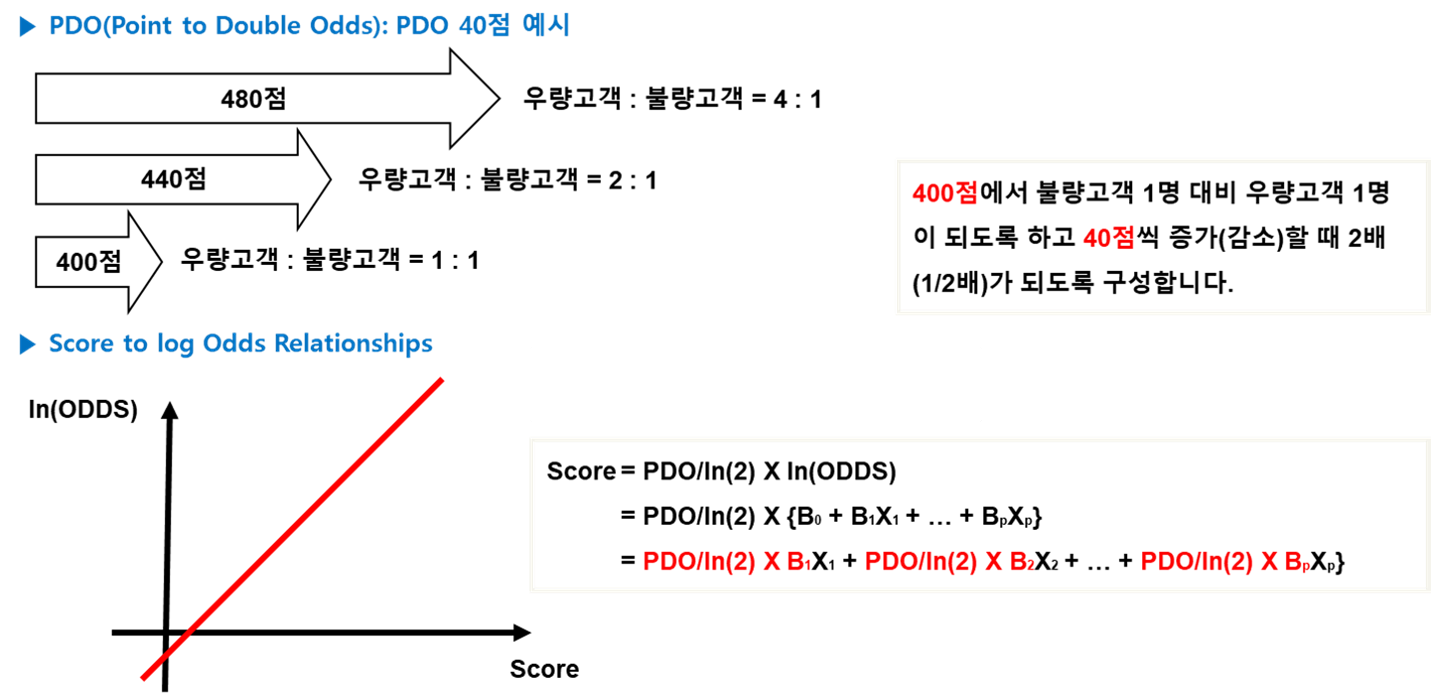

In [ ]:
import plotly.express as px

def scorecard_plot(credit_score, nbin, log_y = True):
  df = pd.DataFrame({'score': credit_score})
  fig = px.histogram(
      df,
      x = "score",
      nbins = nbin,
      title = 'Credit Score Distribution (log scale)',
      labels = {"score" : "Credit Score"},
      template= "plotly_white",
      color_discrete_sequence=['green']
  )
  fig.update_layout(
    yaxis_title='Frequency (log scale)',
    xaxis_title='Credit Score',
    template='plotly_white',
    title='Credit Score Distribution (log)',
    yaxis_type='log',
    yaxis=dict(showgrid=True, gridcolor='lightgray'),
    xaxis=dict(showgrid=False),
    )
  fig.update_traces(marker_line_width=0.5, marker_line_color='black', opacity=0.9)
  fig.update_traces(hovertemplate='Score: %{x}<br>Count: %{y}')
  fig.add_vline(x=600, line_dash="dot", line_color="red", annotation_text="Risk")
  fig.add_vline(x=750, line_dash="dot", line_color="orange", annotation_text="Normal")
  fig.add_vline(x=950, line_dash="dot", line_color="green", annotation_text="Good")

  fig.show()

PDO = 40
base_score = 650
base_odds = 50

test_stack = ensemble_list[8].get_meta_features(data_dict)
meta_model = ensemble_list[8].meta_model

def credit_scoring(pdo, base_score, base_odds, pred, model):
  factor = PDO / math.log(2)
  offset = base_score - (factor * math.log(base_odds))
  coefs = np.append(-model.intercept_, -model.coef_[0])
  weights = factor * coefs
  pred_with_bias = np.column_stack((np.ones(pred.shape[0]), pred))
  score = np.round((pred_with_bias @ weights) + offset)
  score = np.clip(score, 0, 1000)
  return np.round(score)

credit_score = credit_scoring(PDO, base_score, base_odds, test_stack, meta_model)

scorecard_plot(credit_score, 20)

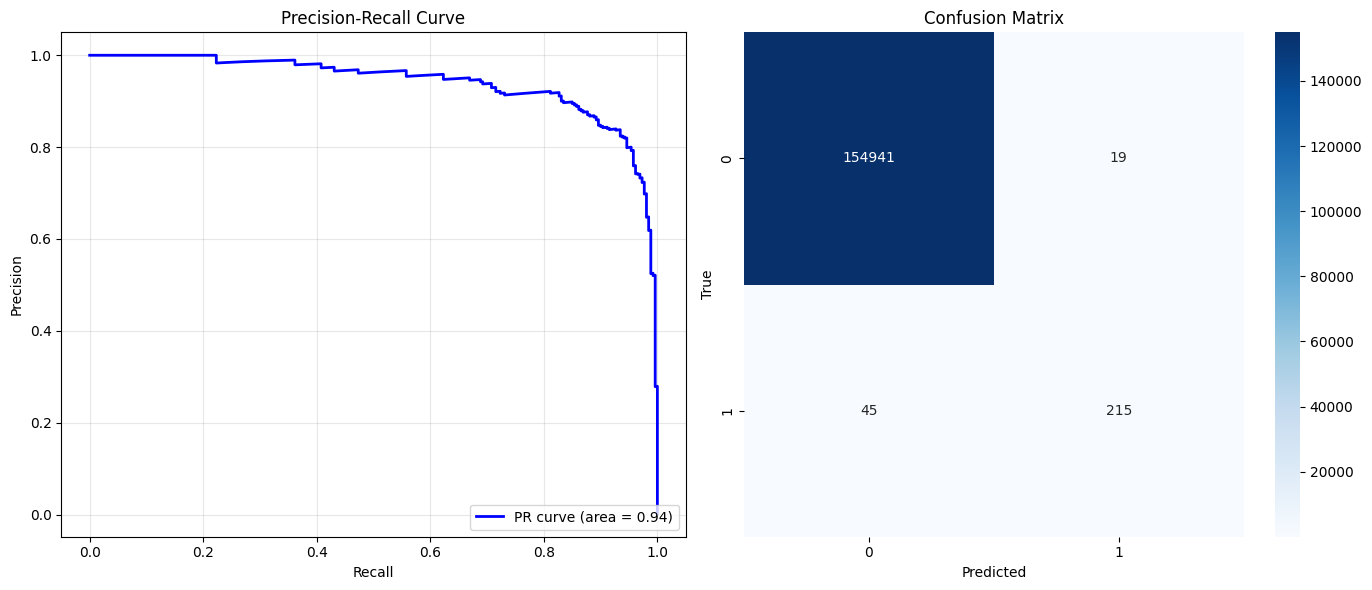

In [ ]:
# 평가 시각화
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_mat(y_test, y_pred, y_pred_proba):
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)

    plt.figure(figsize=(14, 6))

    plt.subplot(1,2,1)
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha = 0.3)

    plt.subplot(1,2,2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap= 'Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.show()

stack_ensemble = ensemble_list[8]
y_pred = stack_ensemble.predict(test_stack)
y_pred_proba = stack_ensemble.predict_proba(test_stack)[:, 1]

plot_pr_mat(y_test_ml, y_pred, y_pred_proba)

In [ ]:
from scipy.stats import ks_2samp

# 정상 vs 부실의 예측 점수 분포 비교
score_non_event = y_pred_proba[y_test_ml == 0]
score_event = y_pred_proba[y_test_ml == 1]

ks_stat, p_value = ks_2samp(score_event, score_non_event)

print(f"p-value: {p_value:.4e}")

p-value: 0.0000e+00


### Dashboard Dataframe

In [23]:
# DASHBOARD_DF
import re

def clean_column(col):
    # 와일드카드 제거
    if '*' in col:
        col = col.replace('_*', '')
    # _nan 제거
    col = re.sub(r'_nan$', '', col)
    # _숫자 또는 _숫자.숫자 제거
    col = re.sub(r'(_\d+(\.\d+)?)$', '', col)
    return col

test['PYE_SC0000000'] = test['PYE_SC0000000'].apply(credit_grade)

inf_cols = ['BASE_YM', 'CUST_ID', 'SEX', 'AGE', 'JB_TP', 'HOME_ADM' ,'HB_1ST']
eff_cols = list(set([clean_column(col) for col in test_ml.columns]
                    + ['HOUS_LN_BAL', 'CRDT_LN_BAL', 'SHP_LN_BAL', 'PYE_ICM']))

test_cols = inf_cols + eff_cols
dash_df = test[test_cols]
dash_df['PREDICTED_POOR'] = y_pred
dash_df['PREDICTED_SCORE'] = credit_score

In [17]:
dash_df.to_csv('/content/drive/MyDrive/dash_df.csv')

In [49]:
note[note['필드명'] == 'PYE_ICM']

,No,필드명,설명,코드여부,타입
39,40,PYE_ICM,전년도 추정 연소득,N,Int


In [7]:
import pandas as pd
dash_df = pd.read_csv('/content/drive/MyDrive/dash_df.csv')
dash_df['CRDT_LN_BAL'].describe()

,CRDT_LN_BAL
count,155220.000000
mean,3820.011049
std,10974.659473
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,191807.000000


In [ ]:
# DICE Dashboard
import pandas as pd
import numpy as np
import dice_ml

def prepare_test_data(x_test: pd.DataFrame, y_test: pd.Series) -> pd.DataFrame:
    df = x_test.copy()
    df['Poor'] = y_test.values
    return df

def get_continuous_features(df: pd.DataFrame, removal: str) -> list:
    continuous_features = df.select_dtypes(include=['int64']).columns.tolist()
    if removal in continuous_features:
        continuous_features.remove(removal)
    return continuous_features

def create_dice_explainer(df: pd.DataFrame, continuous_features: list, outcome_name: str, model) -> dice_ml.Dice:
    # df = df.astype(int)
    dice_data = dice_ml.Data(
        dataframe=df,
        continuous_features=continuous_features,
        outcome_name=outcome_name
    )
    dice_model = dice_ml.Model(model=model, backend='sklearn')
    return dice_ml.Dice(dice_data, dice_model, method='kdtree')

def generate_counterfactual_for_sample(sample: pd.DataFrame, dice_exp: dice_ml.Dice, continuous_features: list, ref_df) -> list:
    """
    주어진 샘플에 대해 Dice-ML로 카운터팩추얼을 생성하고,
    원본과 달라진 컬럼(Changed_cols)을 리스트 형태로 반환.
    """
    sample_data = sample.drop(columns=['Poor'])
    cf = dice_exp.generate_counterfactuals(
        sample_data,
        total_CFs=1,
        desired_class='opposite',
        features_to_vary=continuous_features
    )
    cf_df = cf.cf_examples_list[0].final_cfs_df.iloc[0]
    sample_cf = sample.iloc[0]
    diff = cf_df - sample_cf
    not_diff = (diff != 0)
    not_poor = (diff.index != 'Poor')
    not_num_suffix = ~diff.index.to_series().str.match(r'.*_(?:\d+(?:\.\d+)?|\*)$')
    mask = not_diff & not_poor & not_num_suffix
    arrows = np.where(diff[mask] > 0, '↓', '↑')

    note_map = dict(zip(ref_df['필드명'], ref_df['설명']))
    explanation = [
        note_map.get(col, col) for col in diff.index[mask]
    ]
    result = [f"{exp}{arrow}" for exp, arrow in zip(explanation, arrows)]
    return result


def generate_counterfactuals_df(df: pd.DataFrame, dice_exp: dice_ml.Dice,
                                features_to_vary: list, informal_df: pd.DataFrame,
                                ref_df : pd.DataFrame) -> pd.DataFrame:
    rows = []
    for idx in df.index:
        sample = df.loc[[idx]]
        changed = generate_counterfactual_for_sample(sample, dice_exp, features_to_vary, ref_df)
        rows.append({
            '개선점': changed,
            'Poor': int(sample.at[idx, 'Poor'])
        })

    dash_cf_df = pd.DataFrame(rows)
    result_df = pd.concat(
        [informal_df.reset_index(drop=True), dash_cf_df],
        axis=1
    )
    return result_df

if __name__ == '__main__':
    test_data_cf = prepare_test_data(x_test_ml, y_test_ml)
    test_data_cf = test_data_cf.copy().astype(int)
    # test_data_cf 는 'Poor' 컬럼 포함
    pos = test_data_cf[test_data_cf['Poor']==1]
    neg = test_data_cf[test_data_cf['Poor']==0]
    sampled_pos = pos.sample(n=50, random_state=42)
    sampled_neg = neg.sample(n=50, random_state=42)
    sampled_cf = pd.concat([sampled_pos, sampled_neg])
    continuous_features = get_continuous_features(sampled_cf, 'Poor')
    dice_exp = create_dice_explainer(sampled_cf, continuous_features, 'Poor', xgb_opt)
    temp_cols = ['BASE_YM', 'CUST_ID']
    temp_df = test[temp_cols].loc[sampled_cf.index].reset_index(drop=True)
    output_path = '/content/drive/MyDrive/counterfactual.csv'
    result_df = generate_counterfactuals_df(sampled_cf, dice_exp,
                                            continuous_features,
                                            temp_df, note)
    result_df = result_df.explode('개선점').reset_index(drop=True)
    mask = (result_df['Poor'] == 0)
    result_df.loc[mask, '개선점'] = (
        result_df.loc[mask, '개선점'].str.replace(r'[↑↓]', ' 우위', regex=True)
        )
    result_df.to_csv(output_path, index=False)

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/dice_ml/explainer_interfaces/dice_KD.py:95: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.11/dist-packages/dice_ml/explainer_interfaces/dice_KD.py:125: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/dice_ml/explainer_interfaces/dice_KD.py:95: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many tim

In [5]:
!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 47.4 MB/s eta 0:00:00


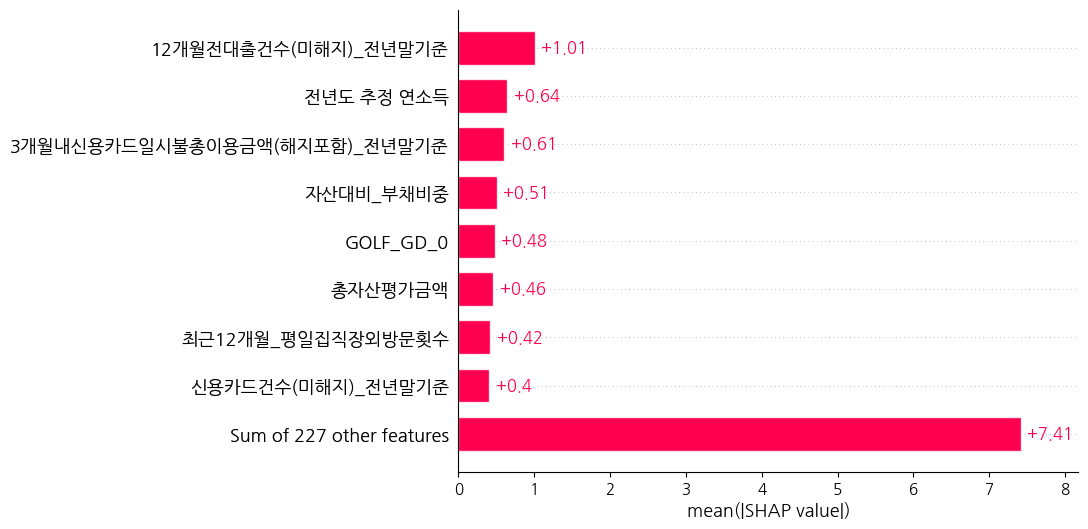

In [10]:
# xgb_opt / shap / note
import shap
import koreanize_matplotlib

shap.initjs()

training_features = xgb_opt.get_booster().feature_names
feature_mapping = dict(zip(note["필드명"], note["설명"]))
test_data = x_test_ml[training_features].rename(columns=feature_mapping)

explainer = shap.TreeExplainer(xgb_opt)
shap_values = explainer(test_data, check_additivity=False)

shap.plots.bar(shap_values, max_display = 9)

In [12]:
feature_df = pd.DataFrame(test_data.columns, columns=['feature'])

mean_shap = shap_values.values.mean(axis=0)
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

feature_df['mean_shap'] = mean_shap
feature_df['mean_abs_shap'] = mean_abs_shap

feature_df = feature_df.sort_values(by='mean_abs_shap', ascending=False).reset_index(drop=True)

print(feature_df.head(10))
feature_df.to_csv('/content/drive/MyDrive/shap.csv')

                        feature  mean_shap  mean_abs_shap
0          12개월전대출건수(미해지)_전년말기준  -0.806001       1.008766
1                    전년도 추정 연소득  -0.457675       0.641030
2  3개월내신용카드일시불총이용금액(해지포함)_전년말기준  -0.318601       0.607399
3                     자산대비_부채비중  -0.392388       0.505539
4                     GOLF_GD_0  -0.304544       0.479644
5                       총자산평가금액  -0.407220       0.457118
6             최근12개월_평일집직장외방문횟수  -0.422021       0.422906
7             신용카드건수(미해지)_전년말기준  -0.316913       0.403355
8              총약정금액(미해지)_전년말기준  -0.322879       0.372300
9                  B1Y_MOB_OS_0  -0.217942       0.349914


In [15]:
feature_df.sort_values(by='mean_shap', ascending = False)

,feature,mean_shap,mean_abs_shap
10,MX_SHP_ADM_nan,0.288531,0.288537
36,COM_ADM_nan,0.088272,0.088272
23,TRAVEL_GD_*,0.051072,0.172470
34,B1Y_MOB_OS_2,0.036845,0.091589
42,APP_GD_*,0.028558,0.071906
...,...,...,...
3,자산대비_부채비중,-0.392388,0.505539
5,총자산평가금액,-0.407220,0.457118
6,최근12개월_평일집직장외방문횟수,-0.422021,0.422906
1,전년도 추정 연소득,-0.457675,0.641030
